In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from satforecast.data import data
from satforecast.modeling.model_selection import rolling_batch
from satforecast.modeling.train import train

data.download()
image_dir = data.process_gs_rainfall_daily(scale=0.1)
image_files = data.get_files(image_dir, '*.npy')

In [2]:
class ConvRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernal_size_, padding_):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)

    def forward(self, in_tensor, h):
        h = torch.cat((in_tensor, h), dim=1)
        h = torch.tanh(self.conv1(h))
        h = torch.tanh(self.conv2(h))
        return self.conv3(h), h

    def init_hidden(self, batch_size, image_size):
        return torch.zeros(batch_size, self.hidden_channels, *image_size)

    def predict(self, X):
        seq_len = X.shape[1]
        
        hidden = self.init_hidden(X.shape[0], X.shape[-2:])

        for step in range(seq_len - 1):
            _, hidden = self.forward(X[:,step], hidden)

        pred, _ = self.forward(X[:, -1], hidden)
        return pred

Batch 0: Validation loss = 0.17362764477729797, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 1: Validation loss = 0.17121726274490356, Train time = 0.0, Update time = 0.0, Validation time = 0.0

!!! Early stopping triggered after 0 epochs and 2 batches !!!



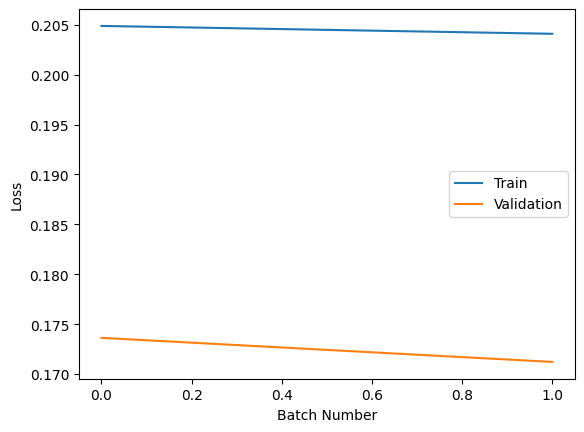

In [3]:
# Test train function
TEST_N_IMAGES = 100
test_image_files = image_files[:TEST_N_IMAGES]
test_crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)

train_loss, val_loss = train(
    model = test_crnn,
    model_name = 'test_crnn_v0',
    criterion = nn.MSELoss(),
    optimizer = torch.optim.Adam(test_crnn.parameters()),
    files_list = test_image_files,
    train_frac = 0.6,
    val_frac = 0.1,
    seq_len = 5,
    batch_size = 5,
    max_epochs = 3,
    val_level = 'batch',
    early_stopping = True,
    min_improv = 0.003,
    max_iter_improv = 1,
    log_level = 1
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

## Semi-full training

Batch 0: Validation loss = 0.07626155018806458, Train time = 0.0, Update time = 0.0, Validation time = 0.1
Batch 1: Validation loss = 0.07464110106229782, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 2: Validation loss = 0.07300161570310593, Train time = 0.0, Update time = 0.0, Validation time = 0.1
Batch 3: Validation loss = 0.07133535295724869, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 4: Validation loss = 0.0696297436952591, Train time = 0.0, Update time = 0.0, Validation time = 0.1
Batch 5: Validation loss = 0.06790092587471008, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 6: Validation loss = 0.06614693254232407, Train time = 0.0, Update time = 0.0, Validation time = 0.1
Batch 7: Validation loss = 0.06437736749649048, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 8: Validation loss = 0.06259073317050934, Train time = 0.0, Update time = 0.0, Validation time = 0.0
Batch 9: Validation loss = 0.060781702

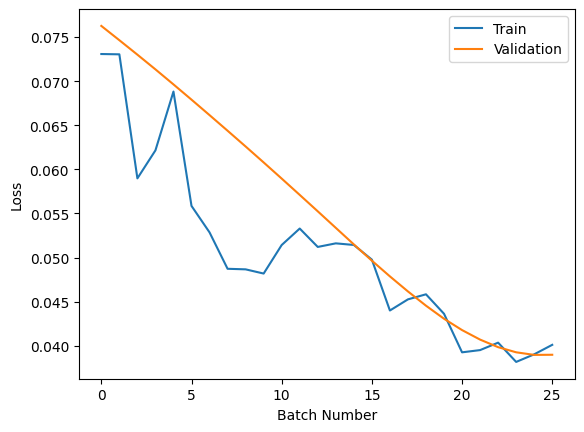

In [6]:
DEV_N_IMAGES = 500
TRAIN_FRAC = 0.6
VAL_FRAC = 0.05
SEQ_LEN = 5
BATCH_SIZE = 5

dev_image_files = image_files[:DEV_N_IMAGES]
dev_crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)

train_loss, val_loss = train(
    model = dev_crnn,
    model_name = 'dev_crnn_v0',
    criterion = nn.MSELoss(),
    optimizer = torch.optim.Adam(dev_crnn.parameters()),
    files_list = dev_image_files,
    train_frac = 0.6,
    val_frac = 0.05,
    seq_len = 5,
    batch_size = 5,
    max_epochs = 3,
    val_level = 'batch',
    early_stopping = True,
    min_improv = 0.001,
    max_iter_improv = 3,
    log_level = 1
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

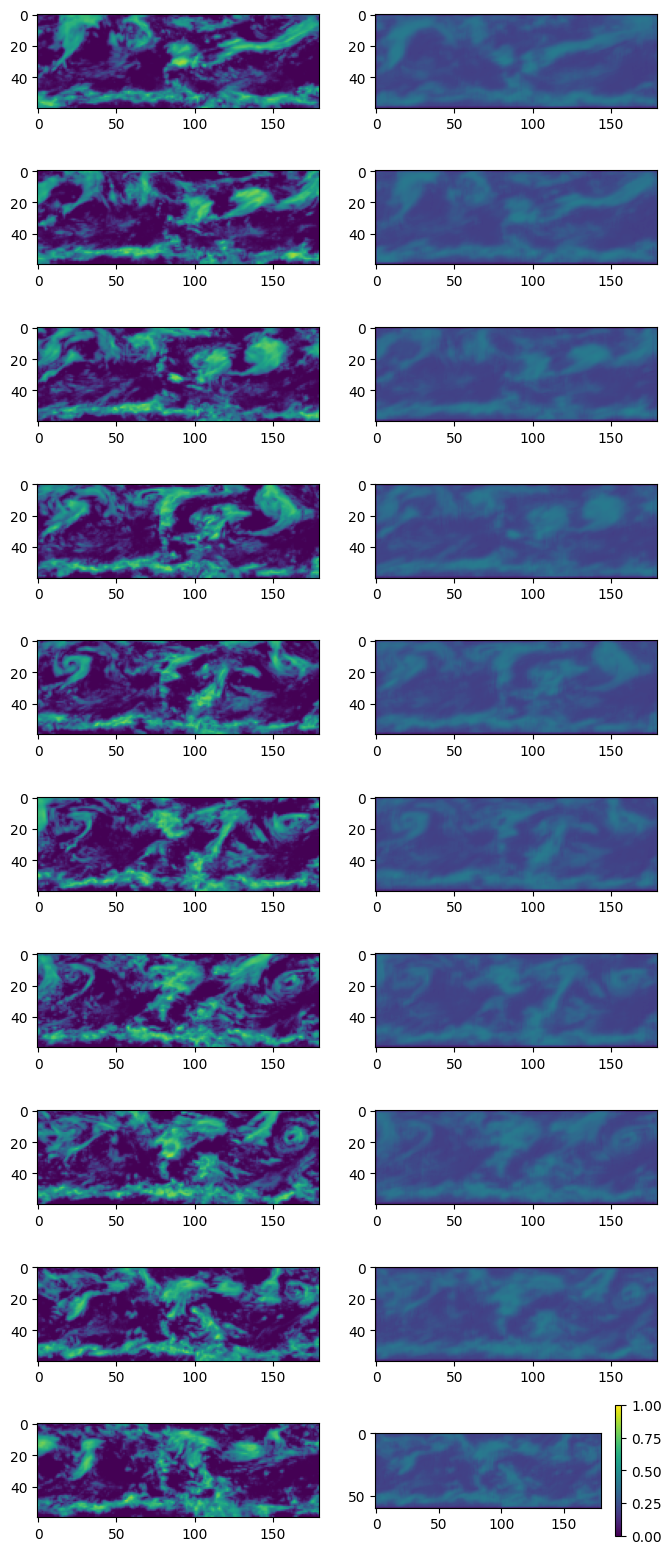

In [7]:
N_DAYS = 10
COLS = 2
IMAGE_SIZE = (60, 180)

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(8, 2*N_DAYS))

dev_crnn.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + 5 + 1], start=0, stop=5 + 1, seq_len=5)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(dev_crnn.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y.astype('float32'), vmin=0, vmax=1)

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred.astype('float32'), vmin=0, vmax=1)

plt.colorbar();